# TWAS tissue comparison

In [1]:
import numpy as np
import pandas as pd
from venn import venn
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

## Prepare data

In [2]:
def limiting_features(set_dict, f1, f2):
    xx = len(set_dict[f1] & set_dict[f2]) / len(set_dict[f2]) * 100
    print("Comparing %s with %s: %0.2f%%" % (f1, f2, xx))
    print("Features in common: %d" % len(set_dict[f1] & set_dict[f2]))

### Load PGC2+CLOZUK

In [3]:
pgc2_file = '/ceph/projects/v4_phase3_paper/inputs/sz_gwas/pgc2_clozuk/map_phase3/_m/libd_hg38_pgc2sz_snps.tsv'
pgc2_df = pd.read_csv(pgc2_file, sep='\t', low_memory=False, index_col=0)

/home/jbenja13/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Load TWAS associations

In [4]:
caudate_file = '/ceph/projects/v4_phase3_paper/analysis/twas/'+\
              'gene_weights/fusion_pgc2/summary_stats/_m/fusion_associations.txt'
caudate0 = pd.read_csv(caudate_file, sep='\t')
caudate = caudate0[(caudate0['FDR'] <= 0.05)].copy()
print(caudate.shape[0])

684


In [5]:
dlpfc_file = '/ceph/users/jbenja13/phase3_paper/phase2/twas/extract_twas/_m/dlpfc_twas_assocations_fusion.csv'
dlpfc0 = pd.read_csv(dlpfc_file, low_memory=False)
dlpfc0 = dlpfc0[(dlpfc0['feature'] == 'gene') & (dlpfc0['region'] == 'DLPFC')].drop('FILE', axis=1).copy()
dlpfc0 = dlpfc0.loc[:, ['ID', 'genesymbol', 'CHR', 'P0', 'P1', 'HSQ', 'BEST.GWAS.ID', 'BEST.GWAS.Z', 
                        'EQTL.ID', 'EQTL.R2', 'EQTL.Z', 'EQTL.GWAS.Z', 'NSNP', 'NWGT', 'MODEL', 
                        'MODELCV.R2', 'MODELCV.PV', 'TWAS.Z', 'TWAS.P', 'TWAS.FDR', 'TWAS.Bonf',
                        'BEST.GWAS.pos_hg19', 'BEST.GWAS.pos_hg38']]\
               .rename(columns={'ID': 'FILE', 'genesymbol': 'ID', 'TWAS.FDR': 'FDR'})
dlpfc0.FILE = dlpfc0.FILE.str.replace('\\..*', '', regex=True)
dlpfc = dlpfc0[(dlpfc0['FDR'] <= 0.05)]
print(dlpfc.shape[0])

406


In [6]:
hippo_file = '/ceph/users/jbenja13/phase3_paper/phase2/twas/extract_twas/_m/hippo_twas_assocations_fusion.csv'
hippo0 = pd.read_csv(hippo_file, low_memory=False)
hippo0 = hippo0[(hippo0['feature'] == 'gene') & (hippo0['region'] == 'HIPPO')].drop('FILE', axis=1).copy()
hippo0 = hippo0.loc[:, ['ID', 'genesymbol', 'CHR', 'P0', 'P1', 'HSQ', 'BEST.GWAS.ID', 'BEST.GWAS.Z', 
                        'EQTL.ID', 'EQTL.R2', 'EQTL.Z', 'EQTL.GWAS.Z', 'NSNP', 'NWGT', 'MODEL', 
                        'MODELCV.R2', 'MODELCV.PV', 'TWAS.Z', 'TWAS.P', 'TWAS.FDR', 'TWAS.Bonf',
                        'BEST.GWAS.pos_hg19', 'BEST.GWAS.pos_hg38']]\
               .rename(columns={'ID': 'FILE', 'genesymbol': 'ID', 'TWAS.FDR': 'FDR'})
hippo0.FILE = hippo0.FILE.str.replace('\\..*', '', regex=True)
hippo = hippo0[(hippo0['FDR'] <= 0.05)]
print(hippo.shape[0])

270


In [7]:
## Caudate
new_caudate0 = pd.merge(caudate0, pgc2_df, left_on='BEST.GWAS.ID', right_on='our_snp_id', suffixes=['_TWAS', '_PGC2'])
new_caudate0['GWAS.SNP'] = ['Risk SNP' if x <= 5e-8 else 'Other' for x in new_caudate0['P']]
## DLPFC
new_dlpfc0 = pd.merge(dlpfc0, pgc2_df, left_on='BEST.GWAS.ID', right_on='rsid', suffixes=['_TWAS', '_PGC2'])
new_dlpfc0['GWAS.SNP'] = ['Risk SNP' if x <= 5e-8 else 'Other' for x in new_dlpfc0['P']]
## Hippocampus
new_hippo0 = pd.merge(hippo0, pgc2_df, left_on='BEST.GWAS.ID', right_on='rsid', suffixes=['_TWAS', '_PGC2'])
new_hippo0['GWAS.SNP'] = ['Risk SNP' if x <= 5e-8 else 'Other' for x in new_hippo0['P']]

In [8]:
tt = pd.merge(new_caudate0[['FILE', 'ID', 'TWAS.Z', 'FDR', 'GWAS.SNP']].set_index(['FILE', 'ID']).add_prefix('Caudate_'), 
              new_dlpfc0[['FILE', 'ID', 'TWAS.Z', 'FDR', 'GWAS.SNP']].set_index(['FILE', 'ID']).add_prefix('DLPFC_'), 
              left_index=True, right_index=True, how='outer')\
       .merge(new_hippo0[['FILE', 'ID', 'TWAS.Z', 'FDR', 'GWAS.SNP']].set_index(['FILE', 'ID']).add_prefix('HIPPO_'),
              left_index=True, right_index=True, how='outer')\
       .reset_index().rename(columns={'FILE': 'Geneid', 'ID': 'Symbol'})
tt.to_csv('TWAS_gene_tissue_summary.csv', index=False, header=True)
tt.head(2)

/home/jbenja13/.local/lib/python3.9/site-packages/pandas/core/indexes/multi.py:3587: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  uniq_tuples = lib.fast_unique_multiple([self._values, other._values], sort=sort)


,Geneid,Symbol,Caudate_TWAS.Z,Caudate_FDR,Caudate_GWAS.SNP,DLPFC_TWAS.Z,DLPFC_FDR,DLPFC_GWAS.SNP,HIPPO_TWAS.Z,HIPPO_FDR,HIPPO_GWAS.SNP
0,ENSG00000000457,SCYL3,1.090068,0.597981,Other,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000000460,C1orf112,-0.372763,0.892471,Other,NaN,NaN,NaN,NaN,NaN,NaN


## Plot Venn

### Genes

#### Heritable comparison

In [9]:
tissues = {
    'Caudate': set(caudate0.FILE),
    'DLPFC': set(dlpfc0.FILE),
    'Hippocampus': set(hippo0.FILE),
}

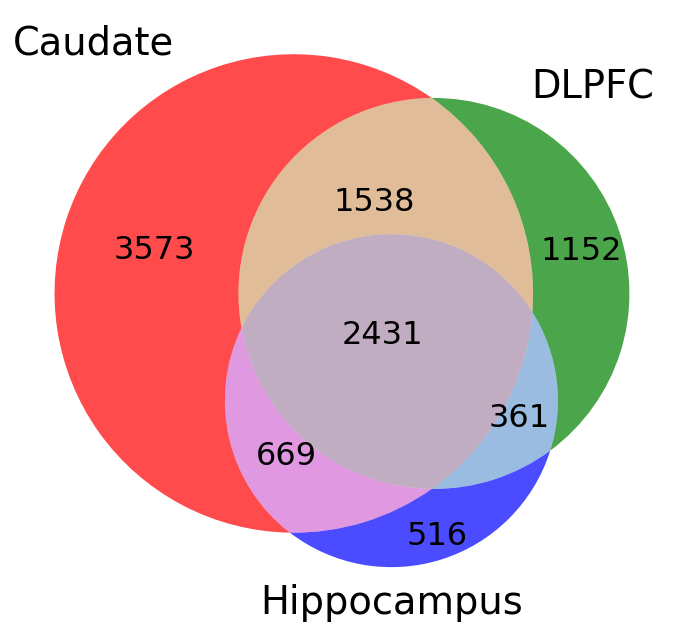

In [10]:
plt.rcParams.update({'font.size': 32, 'font.weight': 'normal'})
plt.figure(figsize=(12,12))

v = venn3([tissues['Caudate'], tissues['DLPFC'], tissues['Hippocampus']], 
          ('Caudate', 'DLPFC', 'Hippocampus'))

v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('001').set_alpha(0.7)

plt.savefig('twas_tissue_comparison_allFeatures.png')
plt.savefig('twas_tissue_comparison_allFeatures.pdf')
plt.savefig('twas_tissue_comparison_allFeatures.svg')
plt.show()

In [11]:
limiting_features(tissues, 'Caudate', 'Hippocampus')
limiting_features(tissues, 'DLPFC', 'Caudate')
limiting_features(tissues, 'DLPFC', 'Hippocampus')

Comparing Caudate with Hippocampus: 77.95%
Features in common: 3100
Comparing DLPFC with Caudate: 48.34%
Features in common: 3969
Comparing DLPFC with Hippocampus: 70.20%
Features in common: 2792


#### TWAS significant

In [12]:
tissues = {
    'Caudate': set(caudate.FILE),
    'DLPFC': set(dlpfc.FILE),
    'Hippocampus': set(hippo.FILE),
}

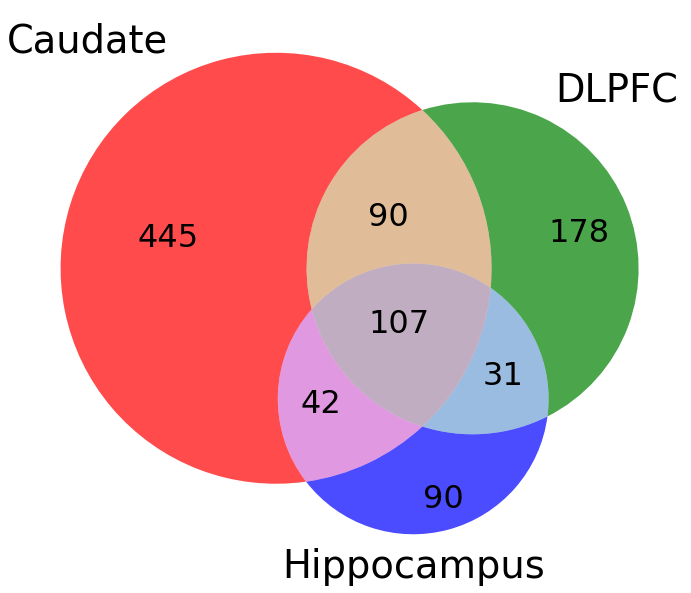

In [13]:
plt.rcParams.update({'font.size': 32, 'font.weight': 'normal'})
plt.figure(figsize=(12,12))

v = venn3([tissues['Caudate'], tissues['DLPFC'], tissues['Hippocampus']], 
          ('Caudate', 'DLPFC', 'Hippocampus'))

v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('001').set_alpha(0.7)

plt.savefig('twas_tissue_comparison_fdr05.png')
plt.savefig('twas_tissue_comparison_fdr05.pdf')
plt.savefig('twas_tissue_comparison_fdr05.svg')
plt.show()

In [14]:
overlapping_twas = new_caudate0.set_index('FILE').loc[set(caudate.FILE) & set(dlpfc.FILE) & set(hippo.FILE), :]
overlapping_twas.to_csv('overlapping_tissue_twasList.txt', sep='\t')

In [15]:
overlapping_twas2 = caudate0.set_index('FILE').loc[set(caudate0.FILE) & set(dlpfc0.FILE) & set(hippo0.FILE), :]
overlapping_twas2.to_csv('overlapping_tissue_twasList_allFeatures.txt', sep='\t')
overlapping_twas2.shape

(2431, 23)

In [16]:
limiting_features(tissues, 'Caudate', 'Hippocampus')
limiting_features(tissues, 'DLPFC', 'Caudate')
limiting_features(tissues, 'DLPFC', 'Hippocampus')

Comparing Caudate with Hippocampus: 55.19%
Features in common: 149
Comparing DLPFC with Caudate: 28.80%
Features in common: 197
Comparing DLPFC with Hippocampus: 51.11%
Features in common: 138


In [17]:
caudate_only_genes = new_caudate0.set_index('FILE')\
                                 .loc[tissues['Caudate'] - tissues['DLPFC'] - tissues['Hippocampus'], :]
caudate_only_genes.to_csv('caudate_only_twasList_genes.txt', sep='\t')
print(caudate_only_genes.shape)
caudate_only_genes.head()

(445, 46)


,ID,CHR_TWAS,P0,P1,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,EQTL.R2,EQTL.Z,...,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp,GWAS.SNP
FILE,,,,,,,,,,,,,,,,,,,,,
ENSG00000198315,ZKSCAN8,6,28141910,28159472.0,0.105032,chr6:28426903:C:T,-13.512,chr6:28159843:T:C,0.100639,6.564859,...,1.2652,0.017409,1.320000e-41,chr6,chr6,28426903,False,rs13201681,False,Risk SNP
ENSG00000158406,HIST1H4H,6,26277609,26285638.0,0.180149,chr6:26463346:G:T,-13.244,chr6:26325000:C:T,0.068548,-5.421896,...,1.3026,0.019964,4.920000e-40,chr6,chr6,26463346,False,rs13195401,False,Risk SNP
ENSG00000100138,SNU13,22,41673930,41690504.0,0.071722,chr22:41944840:T:C,-6.643,chr22:42069256:T:C,-0.002530,-3.179792,...,1.0842,0.012171,3.080000e-11,chr22,chr22,41944840,False,rs1023500,False,Risk SNP
ENSG00000204963,PCDHA7,5,140834248,141012344.0,0.077005,chr5:140841554:G:A,-4.920,chr5:140804857:G:A,0.099376,-6.602974,...,1.0491,0.009745,8.660000e-07,chr5,chr5,140841554,False,rs3756331,False,Other
ENSG00000214331,ENSG00000214331,16,74332402,74368240.0,0.479624,chr16:74547969:C:T,-4.975,chr16:74277555:G:A,0.098800,-7.538111,...,1.0539,0.010560,6.540000e-07,chr16,chr16,74547969,False,rs55960814,False,Other


## Z score comparison

In [18]:
import warnings
warnings.filterwarnings('ignore')

from plotnine import *
from scipy.stats import spearmanr

In [19]:
def save_plot(p, fn):
    for ext in ['png', 'pdf', 'svg']:
        p.save(fn + '.' + ext)

### DLPFC and Caudate

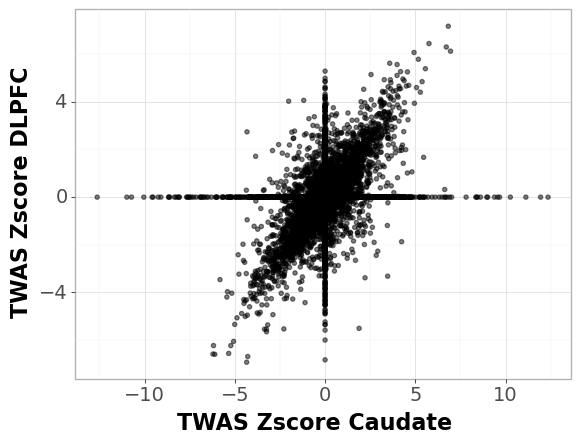

<ggplot: (8744431981490)>

In [20]:
df1 = dlpfc0.merge(caudate0, on=['FILE'], 
                   suffixes=['_dlpfc', '_caudate'], 
                   how='outer').fillna(0)

pp = (ggplot(df1, aes(x='TWAS.Z_caudate', y='TWAS.Z_dlpfc')) + geom_point(alpha=0.5, size=1.25) + 
      labs(x='TWAS Zscore Caudate', y='TWAS Zscore DLPFC') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [21]:
save_plot(pp, 'twas_zscore_comparison_dlpfc_caudate_allFeatures')

In [22]:
df1 = dlpfc0.merge(caudate0, on=['FILE'], 
                   suffixes=['_dlpfc', '_caudate'], 
                   how='inner')
spearmanr(df1['TWAS.Z_caudate'], df1['TWAS.Z_dlpfc'])

SpearmanrResult(correlation=0.7326652177799433, pvalue=0.0)

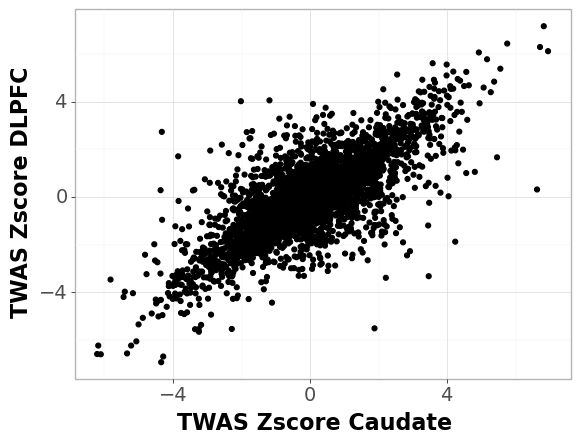

<ggplot: (8744431991733)>

In [23]:
pp = (ggplot(df1, aes(x='TWAS.Z_caudate', y='TWAS.Z_dlpfc')) + geom_point() + 
      labs(x='TWAS Zscore Caudate', y='TWAS Zscore DLPFC') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [24]:
save_plot(pp, 'twas_zscore_comparison_dlpfc_caudate')

#### Significant TWAS

In [25]:
df1 = dlpfc.merge(caudate, on=['FILE'], suffixes=['_dlpfc', '_caudate'])
spearmanr(df1['TWAS.Z_caudate'], df1['TWAS.Z_dlpfc'])

SpearmanrResult(correlation=0.8703546669251974, pvalue=6.642785792421196e-62)

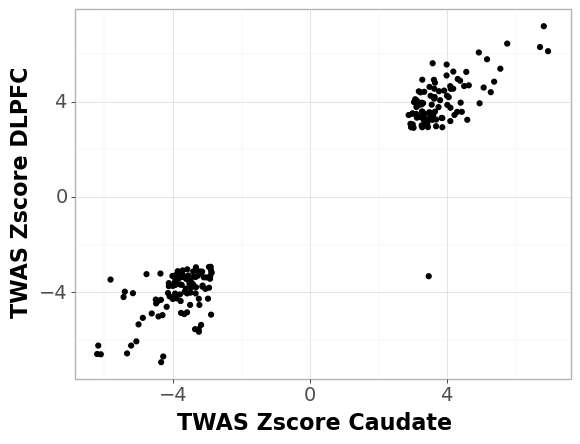

<ggplot: (8744431991712)>

In [26]:
pp = (ggplot(df1, aes(x='TWAS.Z_caudate', y='TWAS.Z_dlpfc')) + geom_point() + 
      labs(x='TWAS Zscore Caudate', y='TWAS Zscore DLPFC') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [27]:
save_plot(pp, 'twas_zscore_comparison_dlpfc_caudate_fdr05')

### Hippocampus and Caudate

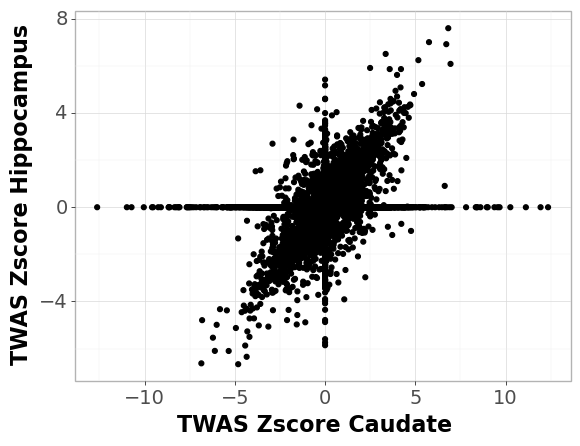

<ggplot: (8744430235531)>

In [28]:
df2 = hippo0.merge(caudate0, on=['FILE'], 
                   suffixes=['_hippo', '_caudate'], 
                   how='outer').fillna(0)

pp = (ggplot(df2, aes(x='TWAS.Z_caudate', y='TWAS.Z_hippo')) + geom_point() + 
      labs(x='TWAS Zscore Caudate', y='TWAS Zscore Hippocampus') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [29]:
save_plot(pp, 'twas_zscore_comparison_hippo_caudate_allFeatures')

In [30]:
df2 = hippo0.merge(caudate0, on=['FILE'], 
                   suffixes=['_hippo', '_caudate'])
spearmanr(df2['TWAS.Z_caudate'], df2['TWAS.Z_hippo'])

SpearmanrResult(correlation=0.7527705409009423, pvalue=0.0)

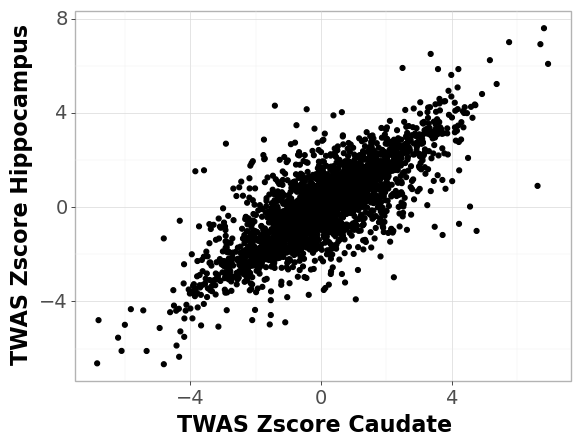

<ggplot: (8744431877006)>

In [31]:
pp = (ggplot(df2, aes(x='TWAS.Z_caudate', y='TWAS.Z_hippo')) + geom_point() + 
      labs(x='TWAS Zscore Caudate', y='TWAS Zscore Hippocampus') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [32]:
save_plot(pp, 'twas_zscore_comparison_hippo_caudate')

#### Significant TWAS

In [33]:
df2 = hippo.merge(caudate, on=['FILE'], 
                  suffixes=['_hippo', '_caudate'])
spearmanr(df2['TWAS.Z_caudate'], df2['TWAS.Z_hippo'])

SpearmanrResult(correlation=0.8910321059314348, pvalue=2.7906764200767958e-52)

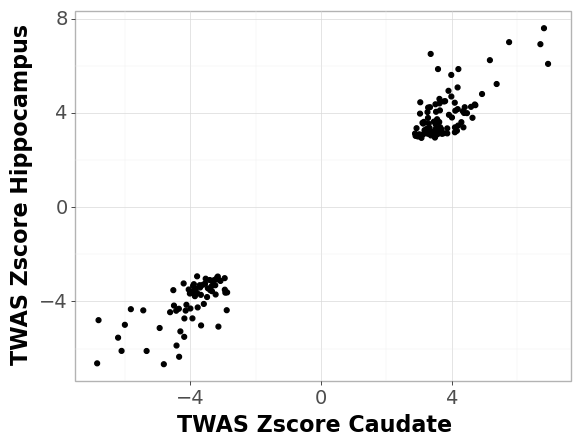

<ggplot: (8744430132276)>

In [34]:
pp = (ggplot(df2, aes(x='TWAS.Z_caudate', y='TWAS.Z_hippo')) + geom_point() + 
      labs(x='TWAS Zscore Caudate', y='TWAS Zscore Hippocampus') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [35]:
save_plot(pp, 'twas_zscore_comparison_hippo_caudate_fdr05')

### DLPFC and Hippocampus

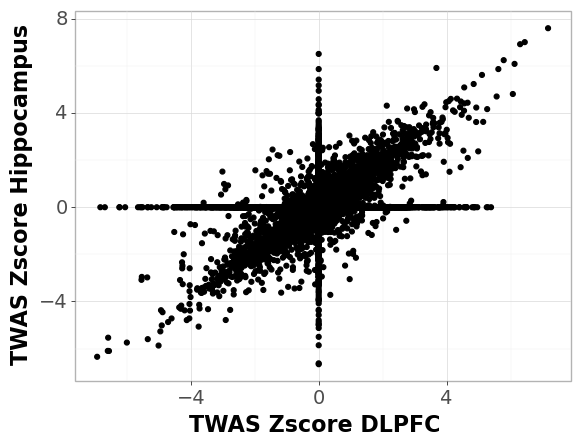

<ggplot: (8744429781014)>

In [36]:
df3 = hippo0.merge(dlpfc0, on=['FILE'], how='outer',
                   suffixes=['_hippo', '_dlpfc']).fillna(0)
pp = (ggplot(df3, aes(x='TWAS.Z_dlpfc', y='TWAS.Z_hippo')) + geom_point() + 
      labs(x='TWAS Zscore DLPFC', y='TWAS Zscore Hippocampus') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [37]:
save_plot(pp, 'twas_zscore_comparison_hippo_dlpfc_allFeatures')

In [38]:
df3 = hippo0.merge(dlpfc0, on=['FILE'], 
                   suffixes=['_hippo', '_dlpfc'])
spearmanr(df3['TWAS.Z_dlpfc'], df3['TWAS.Z_hippo'])

SpearmanrResult(correlation=0.846982546568797, pvalue=0.0)

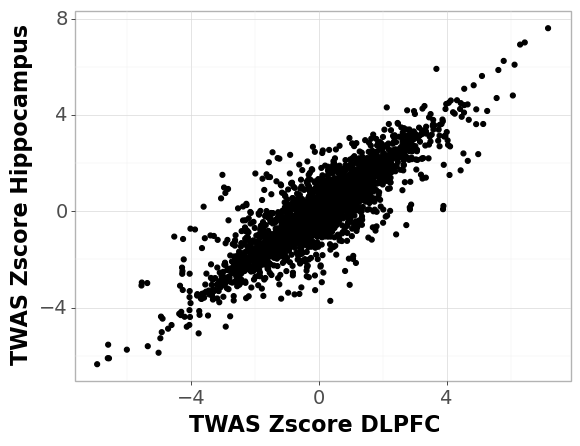

<ggplot: (8744410540508)>

In [39]:
pp = (ggplot(df3, aes(x='TWAS.Z_dlpfc', y='TWAS.Z_hippo')) + geom_point() + 
      labs(x='TWAS Zscore DLPFC', y='TWAS Zscore Hippocampus') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [40]:
save_plot(pp, 'twas_zscore_comparison_hippo_dlpfc')

#### Significant TWAS

In [41]:
df3 = dlpfc.merge(hippo, on=['FILE'], suffixes=['_dlpfc', '_hippo'])
spearmanr(df3['TWAS.Z_hippo'], df3['TWAS.Z_dlpfc'])

SpearmanrResult(correlation=0.907421085257396, pvalue=4.667456229995493e-53)

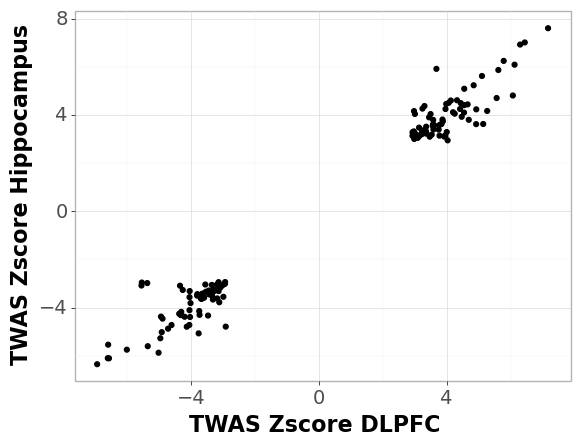

<ggplot: (8744429709852)>

In [42]:
pp = (ggplot(df3, aes(x='TWAS.Z_dlpfc', y='TWAS.Z_hippo')) + geom_point() + 
      labs(x='TWAS Zscore DLPFC', y='TWAS Zscore Hippocampus') + theme_light() + 
      theme(axis_text=element_text(size=14), axis_title=element_text(size=16, face='bold')))
pp

In [43]:
save_plot(pp, 'twas_zscore_comparison_hippo_dlpfc_fdr05')